In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
os.chdir('..')

import pandas as pd
import numpy as np

from Packages.QC import QC

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import balanced_accuracy_score,roc_auc_score,classification_report, f1_score

In [18]:
import joblib

# Import raw data

In [30]:
raw = pd.read_csv('data/diabetes/diabetes_prediction_dataset.csv')
QC(raw).qc()

,Example,Type,N_rows,Missing values,Unique values,Most frequent,Second most frequent,Third most frequent,25th percentile,50th percentile,75th percentile,Maximum value,Minimum value,Standard deviation
HbA1c_level,5.0,float64,100000,0,18,6.6,5.7,6.5,4.8,5.8,6.2,9.0,3.5,1.070672
age,37.0,float64,100000,0,102,80.0,51.0,47.0,24.0,43.0,60.0,80.0,0.08,22.51684
blood_glucose_level,130,int64,100000,0,18,130,159,140,100.0,140.0,159.0,300.0,80.0,40.708136
bmi,14.26,float64,100000,0,4247,27.32,23.0,27.12,23.63,27.32,29.58,95.69,10.01,6.636783
diabetes,0,int64,100000,0,2,0,1,NaN,0.0,0.0,0.0,1.0,0.0,0.278883
gender,Male,object,100000,0,3,Female,Male,Other,NaN,NaN,NaN,NaN,NaN,NaN
heart_disease,0,int64,100000,0,2,0,1,NaN,0.0,0.0,0.0,1.0,0.0,0.194593
hypertension,0,int64,100000,0,2,0,1,NaN,0.0,0.0,0.0,1.0,0.0,0.26315
smoking_history,never,object,100000,0,6,No Info,never,former,NaN,NaN,NaN,NaN,NaN,NaN


# Process

### Duplicates

In [43]:
print(raw.duplicated().sum())
raw.drop_duplicates(inplace=True)

3854


### Categorical values

#### option 1

In [44]:
data = raw.drop(columns=['gender','smoking_history'],axis=1)

#### option 2

In [4]:
def process_cat(df, cat):
    for col in cat:
        for val in sorted(list(df[col].unique())):
            key = f'{col}_{val}'
            df[key] = (df[col] == val).astype(float)
    return df

In [5]:
data = process_cat(raw, ['gender','smoking_history'])
data[:3]

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,Female,80.0,0,1,never,25.19,6.6,140,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Male,28.0,0,0,never,27.32,5.7,158,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
data.drop(columns=['gender','smoking_history','smoking_history_No Info','smoking_history_ever','smoking_history_not current'],axis=1,inplace=True)
data[:3]

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_current,smoking_history_former,smoking_history_never
0,80.0,0,1,25.19,6.6,140,0,1.0,0.0,0.0,0.0,0.0,1.0
1,54.0,0,0,27.32,6.6,80,0,1.0,0.0,0.0,0.0,0.0,0.0
2,28.0,0,0,27.32,5.7,158,0,0.0,1.0,0.0,0.0,0.0,1.0


In [7]:
QC(data).qc()

,Example,Type,N_rows,Missing values,Unique values,Most frequent,Second most frequent,Third most frequent,25th percentile,50th percentile,75th percentile,Maximum value,Minimum value,Standard deviation
HbA1c_level,6.50,float64,96146,0,18,6.60,5.7,6.5,4.8,5.80,6.20,9.00,3.50,1.073232
age,80.00,float64,96146,0,102,80.00,51.0,47.0,24.0,43.00,59.00,80.00,0.08,22.462948
blood_glucose_level,160.00,int64,96146,0,18,159.00,130.0,126,100.0,140.00,159.00,300.00,80.00,40.909771
bmi,26.68,float64,96146,0,4247,27.32,23.0,27.12,23.4,27.32,29.86,95.69,10.01,6.767716
diabetes,0.00,int64,96146,0,2,0.00,1.0,NaN,0.0,0.00,0.00,1.00,0.00,0.283616
gender_Female,1.00,float64,96146,0,2,1.00,0.0,NaN,0.0,1.00,1.00,1.00,0.00,0.492875
gender_Male,1.00,float64,96146,0,2,0.00,1.0,NaN,0.0,0.00,1.00,1.00,0.00,0.492843
gender_Other,0.00,float64,96146,0,2,0.00,1.0,NaN,0.0,0.00,0.00,1.00,0.00,0.013681
heart_disease,0.00,int64,96146,0,2,0.00,1.0,NaN,0.0,0.00,0.00,1.00,0.00,0.197833
hypertension,0.00,int64,96146,0,2,0.00,1.0,NaN,0.0,0.00,0.00,1.00,0.00,0.267544


### Resampling

In [8]:
raw['diabetes'].value_counts()

diabetes
0    87664
1     8482
Name: count, dtype: int64

# Train val and test split

In [45]:
X = data.drop(columns=['diabetes'])
y = data['diabetes']

In [46]:
# Split the data into temp (90%) and test (10%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=100, stratify=y)

# Split the remaining data into train (70%) and validation (30%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=100, stratify=y_temp)

print(f'Shape before split: {data.shape}\n\n')
print(f'''After split\nX_train: {X_train.shape}\t\tX_val: {X_val.shape}\t\tX_test: {X_test.shape}\n
y_train: Shape - {y_train.shape}\t\ty_val shape - {y_val.shape}\t\ty_test shape - {y_test.shape}
\n\n\ny_train Distribution - {y_train.value_counts()}\n\n\ny_val Distribution - {y_val.value_counts()}\n\n\ny_test Distribution - {y_test.value_counts()}''')

Shape before split: (96146, 7)


After split
X_train: (60571, 6)		X_val: (25960, 6)		X_test: (9615, 6)

y_train: Shape - (60571,)		y_val shape - (25960,)		y_test shape - (9615,)



y_train Distribution - diabetes
0    55227
1     5344
Name: count, dtype: int64


y_val Distribution - diabetes
0    23670
1     2290
Name: count, dtype: int64


y_test Distribution - diabetes
0    8767
1     848
Name: count, dtype: int64


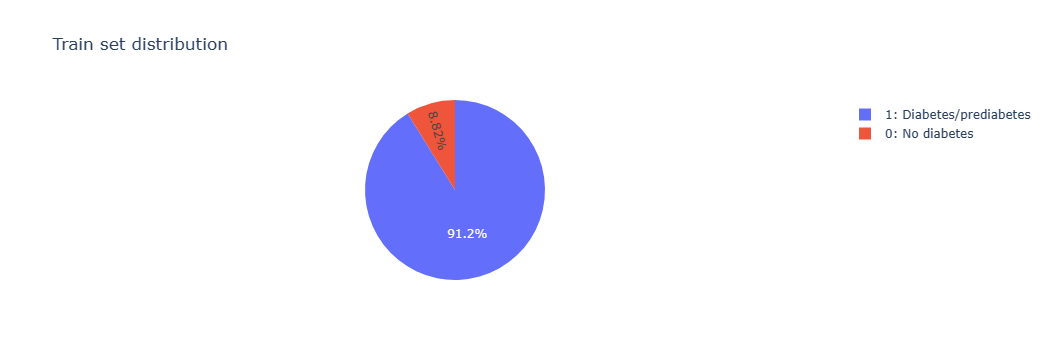

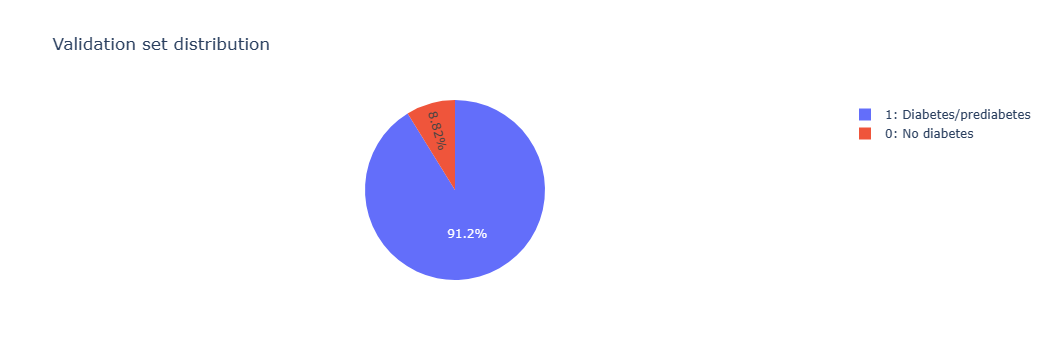

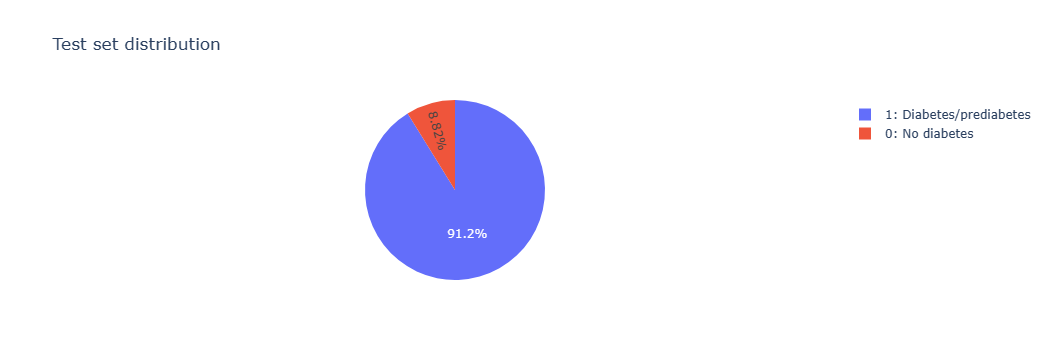

In [47]:
dist_train = px.pie(y_train.value_counts(),values=y_train.value_counts().values,names=['1: Diabetes/prediabetes', '0: No diabetes'],width=400,height=300,title='Train set distribution')
dist_val = px.pie(y_val.value_counts(),values=y_val.value_counts().values,names=['1: Diabetes/prediabetes', '0: No diabetes'],width=400,height=300,title='Validation set distribution')
dist_test = px.pie(y_test.value_counts(),values=y_test.value_counts().values,names=['1: Diabetes/prediabetes', '0: No diabetes'],width=400,height=300,title='Test set distribution')

dist_train.show()
dist_val.show()
dist_test.show()

# XGBoost

In [9]:
from xgboost import XGBClassifier

In [60]:
%%time
xgb = XGBClassifier(learning_rate=0.1,max_depth=3,n_jobs=-1,device='cuda',random_state=100)
xgb.fit(X_train,y_train)

CPU times: total: 1 s
Wall time: 1.02 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=100, ...)

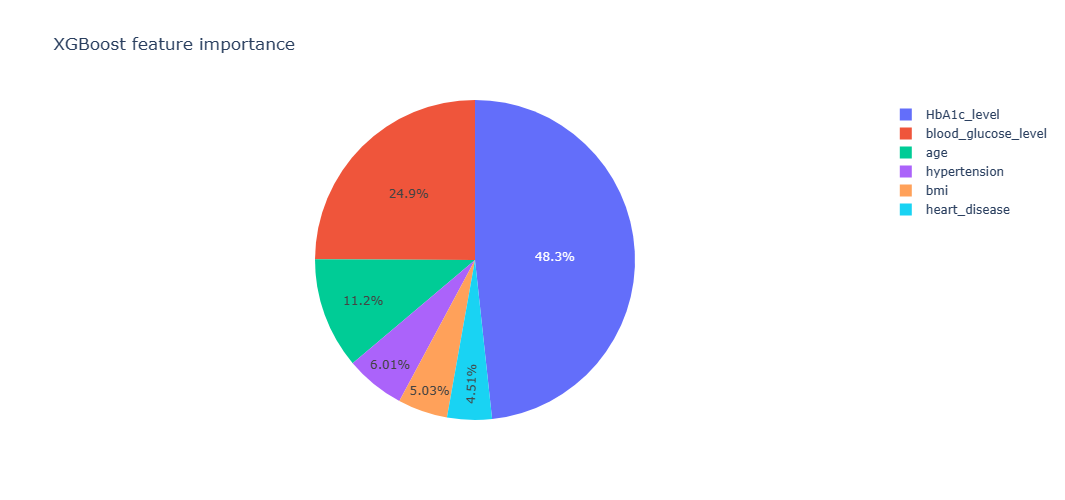

In [61]:
xgbFI = pd.DataFrame({'Feature':X_train.columns.tolist(),'Importance':xgb.feature_importances_})
xgbFIpie = px.pie(xgbFI,values=xgbFI.Importance,names=xgbFI.Feature,width=550,height=500,title='XGBoost feature importance')
xgbFIpie.show()

In [62]:
y_train_xgb = xgb.predict(X_train)
y_val_xgb = xgb.predict(X_val)

bal_acc_train = balanced_accuracy_score(y_train, y_train_xgb)
bal_acc_val = balanced_accuracy_score(y_val, y_val_xgb)

f1_train = f1_score(y_train, y_train_xgb)
f1_val = f1_score(y_val, y_val_xgb)

roc_auc_train = roc_auc_score(y_train, y_train_xgb)
roc_auc_val = roc_auc_score(y_val, y_val_xgb)

print('Train set\n',classification_report(y_train, y_train_xgb))
print('Validation set\n',classification_report(y_val, y_val_xgb))

Train set
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     55227
           1       1.00      0.67      0.80      5344

    accuracy                           0.97     60571
   macro avg       0.98      0.84      0.89     60571
weighted avg       0.97      0.97      0.97     60571

Validation set
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     23670
           1       1.00      0.67      0.80      2290

    accuracy                           0.97     25960
   macro avg       0.98      0.84      0.89     25960
weighted avg       0.97      0.97      0.97     25960



In [63]:
print(f'''Balanced accuracy score\nTrain: {bal_acc_train:.4f}\tVal: {bal_acc_val:.4f}\nf1 score\nTrain: {f1_train:.4f}\tVal: {f1_val:.4f}
roc auc score\nTrain: {roc_auc_train:.4f}\tVal: {roc_auc_val:.4f}''')

Balanced accuracy score
Train: 0.8364	Val: 0.8359
f1 score
Train: 0.8030	Val: 0.8030
roc auc score
Train: 0.8364	Val: 0.8359
